# 项目简介
白细胞（WBC）的识别和分类在血液相关疾病（如白血病、感染）的诊断中发挥着重要作用。由于不同白细胞亚型的形态高度相似，因此在对血细胞涂片进行肉眼观察时，很难对白细胞进行有效而准确的分类。本文提出了一种采用特征融合策略的深度卷积神经网络（DCNN），并将其命名为 WBC-AMNet，用于基于聚焦注意力机制对白细胞亚型进行自动分类。为了使卷积神经网络获得更多的本地化注意力，第一和最后一个卷积层的融合特征是通过结合挤压-激发（SE）和聚集-激发（GE）模块的聚焦注意力机制提取的。新方法成功地对复杂背景下的单核细胞、中性粒细胞、淋巴细胞和嗜酸性粒细胞进行了分类，总体准确率达到 95.66%，优于一般的 CNN。WBC-AMNet 的多重分类准确率在所有情况下均超过 98%。此外，还采用了梯度加权类激活图谱（Gradient-weighted Class Activation Mapping，Grad-CAM）来可视化不同特征图谱的注意力热图。
## ResNeXt：
  VGG和ResNet的成功表明通过堆叠相同形状的Block的方法不仅可以减少超参数的数量，而且能取得SOTA的结果。而GoogleNet和Inception为代表的实践也表明，通过split-transform-merge策略进行精细的网络设计也能达到非常好的效果。ResNeXt的想法就是把这两种好的想法揉到一起。
  ResNeXt并没有像GoogleNet系列那样进行split-transform-merge，而是如下图所示，对相同的子结构进行简单的重复，从而既做了split-transform-merge，同时也没有多少超参数量的增加。  
![](https://ai-studio-static-online.cdn.bcebos.com/41c9f1b158fb4d4ca8027ae91a2651a2447398149c624ed7af4d3f5c9a80ca82)  
上图中（a）结构是resnext的原始结构，（b）和（c）为（a）结构的等价表示，在实际实现中，采用实现起来相对简单的（c）结构，即通过分组卷积的形式来实现resnext的基础block。
## Squeeze-and-Excitation Networks:
  2017年Attention机制被提出，2018年很多的工作都是基于Attention机制进行的，SENet也可以看作是其中之一，该模块可以看作是channel-wies的Attention机制。如下图所示，SENet在常规的卷积之后增加了一条专门计算channel-wise scale的branch，然后把得到的值乘到相应的channel上。
![](https://ai-studio-static-online.cdn.bcebos.com/0e08c0fd759d44d8b0160dd3f3b7e627e1362852755d42b9aa2b28254ed24c8b)  
## SE_ResNeXt:
  SE_ResNeXt是将se模块应用在resnext中的residual block上得到的模型，其他结构参数配置可以了解ResNeXt网络结构。  
## 参考链接:  
[1] [Res-Family: From ResNet to SE-ResNeXt](https://www.cnblogs.com/Matrix_Yao/p/9563063.html#resnext-2017-apr)  
[2] [Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507)  
[3] [Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/abs/1611.05431)  
# 数据介绍
使用公开血细胞数据集



In [ ]:
#图像识别及深度学习代码
#解压血细胞数据集
import os
if not os.path.exists('data/data68409/blood_cell_2'):  
    !cd data/data68409 && unzip -oq blood_cell_2.zip

In [ ]:
#图像识别及深度学习代码
# 解压预训练模型参数 
if not os.path.exists('data/data6595/SE_ResNext50_32x4d_pretrained'):  
    !cd data/data6595 && unzip -oq SE_ResNext50_32x4d_pretrained.zip

### 预处理数据，将其转化为需要的格式

In [ ]:
##图像识别及深度学习代码
# 预处理数据，将其转化为标准格式。同时将数据拆分成两份，以便训练和计算预估准确率
# cell_1：血细胞数据集中2的train部分
# cell_2：血细胞数据集中2的train、test、eval
import codecs,json
import os
import random
import shutil
from PIL import Image

# train_ratio = 0.6  #训练
# eval_ration = 0.2  #验证



##分为训练集、验证集、测试集
def label():
    shutil.copytree('data/data68409/blood_cell_2', 'work/blood_cell_2')
    all_file_dir = 'work/blood_cell_2'
    train_file_dir = 'work/blood_cell_2/train'
    class_list = [c for c in os.listdir(train_file_dir) if os.path.isdir(os.path.join(train_file_dir, c)) and not c.endswith('Set') and not c.startswith('.')]
    class_list.sort()
    print(class_list)
    #已经有分好的
    # train_image_dir = os.path.join(all_file_dir, "trainImageSet")
    # if not os.path.exists(train_image_dir):
    #     os.makedirs(train_image_dir)
        
    # eval_image_dir = os.path.join(all_file_dir, "evalImageSet")
    # if not os.path.exists(eval_image_dir):
    #     os.makedirs(eval_image_dir)

    # test_image_dir = os.path.join(all_file_dir, "testImageSet")   
    # if not os.path.exists(test_image_dir):   
    #     os.makedirs(test_image_dir)

    train_file = codecs.open(os.path.join(all_file_dir, "train.txt"), 'w')
    eval_file = codecs.open(os.path.join(all_file_dir, "eval.txt"), 'w')
    test_file = codecs.open(os.path.join(all_file_dir, "test.txt"), 'w')

    with codecs.open(os.path.join(all_file_dir, "label_list.txt"), "w") as label_list:
        
        flag = 0
        fords = ["test","train","eval"]
        for ford in fords:#根据各个文件夹的名称，生成种类的列表
            ford_path_pre = os.path.join(all_file_dir, ford)
            label_id = 0
            print(ford_path_pre)
            for classes in os.listdir(ford_path_pre):
                print(classes)
                if ford == "test":
                    label_list.write("{0}\t{1}\n".format(label_id, classes))
                image_path_pre = os.path.join(ford_path_pre, classes) 
                print(image_path_pre)
                for file in os.listdir(image_path_pre):
                    try:
                        flag += 1
                        img = Image.open(os.path.join(image_path_pre, file))
                        if  ford == "train":
                            train_file.write("{0}\t{1}\n".format(os.path.join(image_path_pre, file), label_id))
                        elif ford == "test":
                            test_file.write("{0}\t{1}\n".format(os.path.join(image_path_pre, file), label_id))
                            eval_file.write("{0}\t{1}\n".format(os.path.join(image_path_pre, file), label_id))
                    except Exception as e:
                        pass
                        # 存在一些文件打不开，此处需要稍作清洗
                label_id += 1
                
    train_file.close()
    eval_file.close()
    test_file.close()
    label_list.close()

if __name__ == '__main__':
    if not os.path.exists('work/blood_cell_2'):   
        label() 
    else:
        print('已创建标签')

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
work/blood_cell_2/test
MONOCYTE
work/blood_cell_2/test/MONOCYTE
LYMPHOCYTE
work/blood_cell_2/test/LYMPHOCYTE
NEUTROPHIL
work/blood_cell_2/test/NEUTROPHIL
EOSINOPHIL
work/blood_cell_2/test/EOSINOPHIL
work/blood_cell_2/train
MONOCYTE
work/blood_cell_2/train/MONOCYTE
LYMPHOCYTE
work/blood_cell_2/train/LYMPHOCYTE
NEUTROPHIL
work/blood_cell_2/train/NEUTROPHIL
EOSINOPHIL
work/blood_cell_2/train/EOSINOPHIL
work/blood_cell_2/eval
MONOCYTE
work/blood_cell_2/eval/MONOCYTE
LYMPHOCYTE
work/blood_cell_2/eval/LYMPHOCYTE
NEUTROPHIL
work/blood_cell_2/eval/NEUTROPHIL
EOSINOPHIL
work/blood_cell_2/eval/EOSINOPHIL


### 模型训练主体

In [1]:
# -*- coding: UTF-8 -*-
"""
训练常用视觉基础网络，用于分类任务
需要将训练图片，类别文件 label_list.txt 放置在同一个文件夹下
程序会先读取 train.txt 文件获取类别数和图片数量
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from visualdl import LogWriter
import os
import numpy as np
import time
import math
import paddle
import paddle.fluid as fluid
from paddle import nn
import codecs
import logging

from paddle.fluid.initializer import MSRA
from paddle.fluid.initializer import Uniform
from paddle.fluid.param_attr import ParamAttr
from PIL import Image
from PIL import ImageEnhance

train_parameters = {
    "input_size": [3, 224, 224],
    "class_dim": -1,  # 分类数，会在初始化自定义 reader 的时候获得
    "image_count": -1,  # 训练图片数量，会在初始化自定义 reader 的时候获得
    "label_dict": {},
    "data_dir": 'work/blood_cell_2',  # 训练数据存储地址
    "train_file_list": "train.txt",
    "test_file_list": "test.txt",
    "label_file": "label_list.txt",
    "save_freeze_dir": "./freeze-model",
    "save_persistable_dir": "./persistable-params",
    "continue_train":False,        # 是否接着上一次保存的参数接着训练，优先级高于预训练模型
    "pretrained": True,            # 是否使用预训练的模型
    "pretrained_dir": "data/data6595/SE_ResNext50_32x4d_pretrained", 
    "mode": "train",
    "num_epochs": 1,    #训练才知多少合适（1000-40）
    "train_batch_size": 16,  #越大越好（本机max150）
    "mean_rgb": [127.5, 127.5, 127.5],  # 常用图片的三通道均值，通常来说需要先对训练数据做统计，此处仅取中间值
    "use_gpu": True,
    "dropout_seed": None,
    "image_enhance_strategy": {  # 图像增强相关策略
        "need_distort": True,  # 是否启用图像颜色增强
        "need_rotate": True,   # 是否需要增加随机角度
        "need_crop": True,      # 是否要增加裁剪
        "need_flip": True,      # 是否要增加水平随机翻转
        "hue_prob": 0.5,  #图像增强参数
        "hue_delta": 18,   #图像增强参数
        "contrast_prob": 0.5,   #图像增强参数
        "contrast_delta": 0.5,   #图像增强参数
        "saturation_prob": 0.5,   #图像增强参数
        "saturation_delta": 0.5,   #图像增强参数
        "brightness_prob": 0.5,    #图像增强参数
        "brightness_delta": 0.125    #图像增强参数
    },
    "early_stop": {
        ##提前停止的策略
        "sample_frequency": 50,
        "successive_limit": 3,
        "good_acc1": 1.01
    },
    "rsm_strategy": {
        ##rsm策略
        "learning_rate": 0.001,
        "lr_epochs": [20, 40, 60, 80, 100],
        "lr_decay": [1, 0.5, 0.25, 0.1, 0.01, 0.002]
    },
    "momentum_strategy": {
        ##momentum策略
        "learning_rate": 0.001,
        "lr_epochs": [20, 40, 60, 80, 100],
        "lr_decay": [1, 0.5, 0.25, 0.1, 0.01, 0.002]
    },
    "sgd_strategy": {
        ##sgd策略
        "learning_rate": 0.001,
        "lr_epochs": [20, 40, 60, 80, 100],
        "lr_decay": [1, 0.5, 0.25, 0.1, 0.01, 0.002]
    },
    "adam_strategy": {
        ##adam策略
        "learning_rate": 0.002
    }
}

class SRMLayer(nn.Layer):
    def __init__(self, channel):
        super(SRMLayer, self).__init__()

        self.cfc = self.create_parameter(shape=[channel, 2], default_initializer=nn.initializer.Assign(paddle.zeros([channel, 2])))

        self.bn = nn.BatchNorm2D(channel)
        self.activation = nn.Sigmoid()

        setattr(self.cfc, 'srm_param', True)
        setattr(self.bn.weight, 'srm_param', True)
        setattr(self.bn.bias, 'srm_param', True)

    def _style_pooling(self, x, eps=1e-5):
        N, C, _, _ = x.shape

        channel_mean = paddle.mean(paddle.reshape(x, [N, C, -1]), axis=2, keepdim=True)
        channel_var = paddle.var(paddle.reshape(x, [N, C, -1]), axis=2, keepdim=True) + eps
        channel_std = paddle.sqrt(channel_var)

        t = paddle.concat((channel_mean, channel_std), axis=2)
        return t 
    
    def _style_integration(self, t):
        z = t*paddle.reshape(self.cfc, [-1, self.cfc.shape[0], self.cfc.shape[1]])
        tmp = paddle.sum(z, axis=2)
        z = paddle.reshape(tmp, [tmp.shape[0], tmp.shape[1], 1, 1]) # B x C x 1 x 1

        z_hat = self.bn(z)
        g = self.activation(z_hat)

        return g

    def forward(self, x):
        # B x C x 2
        t = self._style_pooling(x)

        # B x C x 1 x 1
        g = self._style_integration(t)

        return x * g

class SELayer(nn.Layer):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2D(1)
        self.activation = nn.Sigmoid()

        self.reduction = reduction

        self.fc = nn.Sequential(
                nn.Linear(channel, channel // self.reduction),
                nn.ReLU(),
                nn.Linear(channel // self.reduction, channel),
        )

    def forward(self, x):
        b, c, _, _ = x.shape

        avg_y = paddle.reshape(self.avgpool(x), [b, c])

        gate = paddle.reshape(self.fc(avg_y), [b, c, 1, 1])
        gate = self.activation(gate)

        return x * gate 

class GELayer(nn.Layer):
    def __init__(self, channel, layer_idx):
        super(GELayer, self).__init__()

        # Kernel size w.r.t each layer for global depth-wise convolution
        kernel_size = [-1, 56, 28, 14, 7][layer_idx]

        self.conv = nn.Sequential(
                        nn.Conv2D(channel, channel, kernel_size= 1, groups=channel), 
                        nn.BatchNorm2D(channel),
                    )

        self.activation = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.shape

        gate = self.conv(x)
        gate = self.activation(gate)

        return x * gate 


##神经网络结构
class SE_ResNeXt():
    def __init__(self, layers=50):
        self.params = train_parameters  #训练参数
        self.layers = layers  #层数
        self.GELayer = GELayer(channel= 2048, layer_idx=1)
        # self.SRMLayer = SRMLayer(channel=32)
        self.SELayer = SELayer(channel=2048)

    def net(self, input, class_dim=1000):
        ##神经网络主体结构
        layers = self.layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            ##50层神经网络的结构参数
            cardinality = 32
            reduction_ratio = 16
            depth = [3, 4, 6, 3]
            num_filters = [128, 256, 512, 1024]

            conv = self.conv_bn_layer(
                ##第一个卷积层参数
                input=input,
                num_filters=64,
                filter_size=7,
                stride=2,
                act='relu',
                name='conv1', 
                lear_rate=0)
            conv_01 = conv 
            # conv = self.GELayer (conv) # GE moduel
            # atten = self.SELayer (drop) # SE moduel
            # atten = SRMLayer (drop) # SRM moduel
            
            conv = fluid.layers.pool2d(
                ##第二个卷积层参数
                input=conv,
                pool_size=3,
                pool_stride=2,
                pool_padding=1,
                pool_type='max')
        elif layers == 101:
            ##101层神经网络结构参数
            cardinality = 32
            reduction_ratio = 16
            depth = [3, 4, 23, 3]
            num_filters = [128, 256, 512, 1024]

            conv = self.conv_bn_layer(
                ##第一层神经网络的结构参数
                input=input,
                num_filters=64,
                filter_size=7,
                stride=2,
                act='relu',
                name="conv1", )
            conv = fluid.layers.pool2d(
                ##第二层神经网络结构参数
                input=conv,
                pool_size=3,
                pool_stride=2,
                pool_padding=1,
                pool_type='max')
        elif layers == 152:
            ##152层神经网络结构参数
            cardinality = 64
            reduction_ratio = 16
            depth = [3, 8, 36, 3]
            num_filters = [128, 256, 512, 1024]

            conv = self.conv_bn_layer(
                input=input,
                num_filters=64,
                filter_size=3,
                stride=2,
                act='relu',
                name='conv1')

            conv = self.conv_bn_layer(
                input=conv,
                num_filters=64,
                filter_size=3,
                stride=1,
                act='relu',
                name='conv2')
            conv = self.conv_bn_layer(
                input=conv,
                num_filters=128,
                filter_size=3,
                stride=1,
                act='relu',
                name='conv3')
            conv = fluid.layers.pool2d(
                ##池化层参数
                input=conv, pool_size=3, pool_stride=2, pool_padding=1, \
                pool_type='max')
        n = 1 if layers == 50 or layers == 101 else 3
        for block in range(len(depth)):##block结构构建
            n += 1
            for i in range(depth[block]):
                if i<30:
                    rate = 0
                elif i<40:
                    rate = 0
                elif i<45:
                    rate = 0.00001
                else:
                    rate = 0.00005
                conv = self.bottleneck_block(##block的瓶颈构建
                    input=conv,
                    num_filters=num_filters[block],
                    stride=2 if i == 0 and block != 0 else 1,
                    cardinality=cardinality,
                    reduction_ratio=reduction_ratio,
                    name=str(n) + '_' + str(i + 1),
                    lear_rate = rate)
        
        # pool_1 = fluid.layers.pool2d(##池化层参数
            # input=conv_01, pool_size=106, pool_type='avg', global_pooling=True,)
        
        # conv_f1 = fluid.layers.conv2d(##BN卷积层参数
        #     input=conv_01,
        #     num_filters=2048,
        #     filter_size=106,
        #     stride=1,
        #     padding=0,
        #     groups=1,
        #     act=None,
        #     bias_attr=False,
        #     param_attr=ParamAttr(name='Conv_final_weights',
        #                         learning_rate= 1       
        #     ))
        # conv_f2 = fluid.layers.pool2d(
        #         ##第二层神经网络结构参数
        #         input=conv_f1,
        #         pool_size=3,
        #         pool_stride=2,
        #         pool_padding=4,
        #         pool_type='max')
         
        conv_01 = fluid.layers.reshape(
            x=conv_01, shape=[-1, 16384, 7, 7])

        conv_f1 = fluid.layers.conv2d(##BN卷积层参数
            input=conv_01,
            num_filters=2048,
            filter_size=1,
            stride=1,
            padding=0,
            groups=1,
            act=None,
            bias_attr=False,
            param_attr=ParamAttr(name='Conv_final_weights',
                                learning_rate= 0.01       
            ))
        
        conv_f1 = fluid.layers.elementwise_mul(x=conv_f1, y=conv, act='relu')

        conv_se = self.squeeze_excitation(##SE策略
            input=conv_f1,
            num_channels=2048,
            reduction_ratio=reduction_ratio,
            name='se_final')

        conv_ge = self.GELayer (conv) # GE moduel

        conv_att = fluid.layers.elementwise_add(x=conv_se, y=conv_ge, axis=0)

        conv = fluid.layers.elementwise_mul(x=conv_att, y=conv, act='relu')

        # conv = conv_ge * conv 

        pool = fluid.layers.pool2d(##池化层参数
            input=conv, pool_size=7, pool_type='avg', global_pooling=True)
        drop = fluid.layers.dropout(##dropout参数
            x=pool, dropout_prob=0.5, seed=self.params['dropout_seed'])
        stdv = 1.0 / math.sqrt(drop.shape[1] * 1.0)


        out = fluid.layers.fc(##最后一个全连接层参数
            input=drop,
            size=class_dim,
            act="softmax",
            param_attr=ParamAttr(
                initializer=fluid.initializer.Uniform(-stdv, stdv),
                name='fc6_weights',
                learning_rate=  0.1),
            bias_attr=ParamAttr(name='fc6_offset'))
        return out

    def shortcut(self, input, ch_out, stride, name):
        ch_in = input.shape[1]
        if ch_in != ch_out or stride != 1:
            filter_size = 1
            return self.conv_bn_layer(
                input, ch_out, filter_size, stride, name='conv' + name + '_prj')
        else:
            return input

    def bottleneck_block(self,
                         input,
                         num_filters,
                         stride,
                         cardinality,
                         reduction_ratio,
                         lear_rate,
                         name=None):
        conv0 = self.conv_bn_layer(##block中第1个卷积层
            input=input,
            num_filters=num_filters,
            filter_size=1,
            act='relu',
            name='conv' + name + '_x1',
            lear_rate = lear_rate)
        conv1 = self.conv_bn_layer(##block中第2个卷积层
            input=conv0,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            groups=cardinality,
            act='relu',
            name='conv' + name + '_x2',
            lear_rate = lear_rate)
        conv2 = self.conv_bn_layer(##block中第3个卷积层
            input=conv1,
            num_filters=num_filters * 2,
            filter_size=1,
            act=None,
            name='conv' + name + '_x3',
            lear_rate = lear_rate)
        scale = self.squeeze_excitation(##SE策略
            input=conv2,
            num_channels=num_filters * 2,
            reduction_ratio=reduction_ratio,
            name='fc' + name)

        short = self.shortcut(input, num_filters * 2, stride, name=name)

        return fluid.layers.elementwise_add(x=short, y=scale, act='relu')

##BN层参数
    def conv_bn_layer(self,
                      input,
                      num_filters,
                      filter_size,
                      stride=1,
                      groups=1,
                      act=None,
                      name=None,
                      lear_rate=1):
        conv = fluid.layers.conv2d(##BN卷积层参数
            input=input,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            act=None,
            bias_attr=False,
            param_attr=ParamAttr(name=name + '_weights',
                                learning_rate= lear_rate       
            ))
        bn_name = name + "_bn"
        return fluid.layers.batch_norm(##返回BN函数
            input=conv,
            act=act,
            param_attr=ParamAttr(name=bn_name + '_scale'),
            bias_attr=ParamAttr(bn_name + '_offset'),
            moving_mean_name=bn_name + '_mean',
            moving_variance_name=bn_name + '_variance')

##squeeze_excitation策略
    def squeeze_excitation(self,
                           input,
                           num_channels,
                           reduction_ratio,
                           name=None):
        pool = fluid.layers.pool2d(##池化层
            input=input, pool_size=0, pool_type='avg', global_pooling=True)
        stdv = 1.0 / math.sqrt(pool.shape[1] * 1.0)
        squeeze = fluid.layers.fc(##通过全连接层实现squeeze
            input=pool,
            size=num_channels // reduction_ratio,
            act='relu',
            param_attr=fluid.param_attr.ParamAttr(
                initializer=fluid.initializer.Uniform(-stdv, stdv),
                name=name + '_sqz_weights'),
            bias_attr=ParamAttr(name=name + '_sqz_offset'))
        stdv = 1.0 / math.sqrt(squeeze.shape[1] * 1.0)
        excitation = fluid.layers.fc(##通过全连接层实现excitation
            input=squeeze,
            size=num_channels,
            act='sigmoid',
            param_attr=fluid.param_attr.ParamAttr(
                initializer=fluid.initializer.Uniform(-stdv, stdv),
                name=name + '_exc_weights'),
            bias_attr=ParamAttr(name=name + '_exc_offset'))
        scale = fluid.layers.elementwise_mul(x=input, y=excitation, axis=0)
        return scale




def init_log_config():
    """
    初始化日志相关配置
    :return:
    """
    global logger
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    log_path = os.path.join(os.getcwd(), 'logs')
    if not os.path.exists(log_path):
        os.makedirs(log_path)
    log_name = os.path.join(log_path, 'train.log')
    sh = logging.StreamHandler()
    fh = logging.FileHandler(log_name, mode='w')
    fh.setLevel(logging.DEBUG)
    formatter = logging.Formatter("%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s")
    fh.setFormatter(formatter)
    sh.setFormatter(formatter)
    logger.addHandler(sh)
    logger.addHandler(fh)


def init_train_parameters():
    """
    初始化训练参数，主要是初始化图片数量，类别数
    :return:
    """
    train_file_list = os.path.join(train_parameters['data_dir'], train_parameters['train_file_list'])
    label_list = os.path.join(train_parameters['data_dir'], train_parameters['label_file'])
    index = 0
    with codecs.open(label_list, encoding='utf-8') as flist:
        lines = [line.strip() for line in flist]
        for line in lines:
            parts = line.strip().split()
            train_parameters['label_dict'][parts[1]] = int(parts[0])
            index += 1
        train_parameters['class_dim'] = index
    with codecs.open(train_file_list, encoding='utf-8') as flist:
        lines = [line.strip() for line in flist]
        train_parameters['image_count'] = len(lines)


def resize_img(img, target_size):
    """
    强制缩放图片
    :param img:
    :param target_size:
    :return:
    """
    target_size = input_size
    img = img.resize((target_size[1], target_size[2]), Image.BILINEAR)
    return img


def random_crop(img, scale=[0.08, 1.0], ratio=[3. / 4., 4. / 3.]):
    aspect_ratio = math.sqrt(np.random.uniform(*ratio))
    w = 1. * aspect_ratio
    h = 1. / aspect_ratio

    bound = min((float(img.size[0]) / img.size[1]) / (w**2),
                (float(img.size[1]) / img.size[0]) / (h**2))
    scale_max = min(scale[1], bound)
    scale_min = min(scale[0], bound)

    target_area = img.size[0] * img.size[1] * np.random.uniform(scale_min,
                                                                scale_max)
    target_size = math.sqrt(target_area)
    w = int(target_size * w)
    h = int(target_size * h)

    i = np.random.randint(0, img.size[0] - w + 1)
    j = np.random.randint(0, img.size[1] - h + 1)

    img = img.crop((i, j, i + w, j + h))
    img = img.resize((train_parameters['input_size'][1], train_parameters['input_size'][2]), Image.BILINEAR)
    return img


def rotate_image(img):
    """
    图像增强，增加随机旋转角度
    """
    angle = np.random.randint(-14, 15)
    img = img.rotate(angle)
    return img


def random_brightness(img):
    """
    图像增强，亮度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['brightness_prob']:
        brightness_delta = train_parameters['image_enhance_strategy']['brightness_delta']
        delta = np.random.uniform(-brightness_delta, brightness_delta) + 1
        img = ImageEnhance.Brightness(img).enhance(delta)
    return img


def random_contrast(img):
    """
    图像增强，对比度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['contrast_prob']:
        contrast_delta = train_parameters['image_enhance_strategy']['contrast_delta']
        delta = np.random.uniform(-contrast_delta, contrast_delta) + 1
        img = ImageEnhance.Contrast(img).enhance(delta)
    return img


def random_saturation(img):
    """
    图像增强，饱和度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['saturation_prob']:
        saturation_delta = train_parameters['image_enhance_strategy']['saturation_delta']
        delta = np.random.uniform(-saturation_delta, saturation_delta) + 1
        img = ImageEnhance.Color(img).enhance(delta)
    return img


def random_hue(img):
    """
    图像增强，色度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['hue_prob']:
        hue_delta = train_parameters['image_enhance_strategy']['hue_delta']
        delta = np.random.uniform(-hue_delta, hue_delta)
        img_hsv = np.array(img.convert('HSV'))
        img_hsv[:, :, 0] = img_hsv[:, :, 0] + delta
        img = Image.fromarray(img_hsv, mode='HSV').convert('RGB')
    return img


def distort_color(img):
    """
    概率的图像增强
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    # Apply different distort order
    if prob < 0.35:
        img = random_brightness(img)
        img = random_contrast(img)
        img = random_saturation(img)
        img = random_hue(img)
    elif prob < 0.7:
        img = random_brightness(img)
        img = random_saturation(img)
        img = random_hue(img)
        img = random_contrast(img)
    return img


def custom_image_reader(file_list, data_dir, mode):
    """
    自定义用户图片读取器，先初始化图片种类，数量
    :param file_list:
    :param data_dir:
    :param mode:
    :return:
    """
    with codecs.open(file_list) as flist:
        lines = [line.strip() for line in flist]

    def reader():
        np.random.shuffle(lines)
        for line in lines:
            if mode == 'train' or mode == 'val':
                img_path, label = line.split()
                img = Image.open(img_path)
                try:
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    if train_parameters['image_enhance_strategy']['need_distort'] == True:
                        img = distort_color(img)
                    if train_parameters['image_enhance_strategy']['need_rotate'] == True:
                        img = rotate_image(img)
                    if train_parameters['image_enhance_strategy']['need_crop'] == True:
                        img = random_crop(img, train_parameters['input_size'])
                    if train_parameters['image_enhance_strategy']['need_flip'] == True:
                        mirror = int(np.random.uniform(0, 2))
                        if mirror == 1:
                            img = img.transpose(Image.FLIP_LEFT_RIGHT)
                    # HWC--->CHW && normalized
                    img = np.array(img).astype('float32')
                    img -= train_parameters['mean_rgb']
                    img = img.transpose((2, 0, 1))  # HWC to CHW
                    img *= 0.007843                 # 像素值归一化
                    yield img, int(label)
                except Exception as e:
                    pass                            # 以防某些图片读取处理出错，加异常处理
            elif mode == 'test':
                img_path = os.path.join(data_dir, line)
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = resize_img(img, train_parameters['input_size'])
                # HWC--->CHW && normalized
                img = np.array(img).astype('float32')
                img -= train_parameters['mean_rgb']
                img = img.transpose((2, 0, 1))  # HWC to CHW
                img *= 0.007843  # 像素值归一化
                yield img

    return reader


def optimizer_momentum_setting():
    """
    阶梯型的学习率适合比较大规模的训练数据
    """
    learning_strategy = train_parameters['momentum_strategy']
    batch_size = train_parameters["train_batch_size"]
    iters = train_parameters["image_count"] // batch_size
    lr = learning_strategy['learning_rate']

    boundaries = [i * iters for i in learning_strategy["lr_epochs"]]
    values = [i * lr for i in learning_strategy["lr_decay"]]
    learning_rate = fluid.layers.piecewise_decay(boundaries, values)
    optimizer = fluid.optimizer.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
    return optimizer


def optimizer_rms_setting():
    """
    阶梯型的学习率适合比较大规模的训练数据
    """
    batch_size = train_parameters["train_batch_size"]
    iters = train_parameters["image_count"] // batch_size
    learning_strategy = train_parameters['rsm_strategy']
    lr = learning_strategy['learning_rate']

    boundaries = [i * iters for i in learning_strategy["lr_epochs"]]
    values = [i * lr for i in learning_strategy["lr_decay"]]

    optimizer = fluid.optimizer.RMSProp(
        learning_rate=fluid.layers.piecewise_decay(boundaries, values))

    return optimizer


def optimizer_sgd_setting():
    """
    loss下降相对较慢，但是最终效果不错，阶梯型的学习率适合比较大规模的训练数据
    """
    learning_strategy = train_parameters['sgd_strategy']
    batch_size = train_parameters["train_batch_size"]
    iters = train_parameters["image_count"] // batch_size
    lr = learning_strategy['learning_rate']

    boundaries = [i * iters for i in learning_strategy["lr_epochs"]]
    values = [i * lr for i in learning_strategy["lr_decay"]]
    learning_rate = fluid.layers.piecewise_decay(boundaries, values)
    optimizer = fluid.optimizer.SGD(learning_rate=learning_rate)
    return optimizer


def optimizer_adam_setting():
    """
    能够比较快速的降低 loss，但是相对后期乏力
    """
    learning_strategy = train_parameters['adam_strategy']
    learning_rate = learning_strategy['learning_rate']
    optimizer = fluid.optimizer.Adam(learning_rate=learning_rate)
    return optimizer


def load_params(exe, program):
    if train_parameters['continue_train'] and os.path.exists(train_parameters['save_persistable_dir']):
        logger.info('load params from retrain model')
        fluid.io.load_persistables(executor=exe,
                                   dirname=train_parameters['save_persistable_dir'],
                                   main_program=program)
    elif train_parameters['pretrained'] and os.path.exists(train_parameters['pretrained_dir']):
        logger.info('load params from pretrained model')
        def if_exist(var):
            return os.path.exists(os.path.join(train_parameters['pretrained_dir'], var.name))

        fluid.io.load_vars(exe, train_parameters['pretrained_dir'], main_program=program,
                           predicate=if_exist)


def train():
    train_prog = fluid.Program()
    train_startup = fluid.Program()
    logger.info("create prog success")
    logger.info("train config: %s", str(train_parameters))
    logger.info("build input custom reader and data feeder")
    file_list = os.path.join(train_parameters['data_dir'], "train.txt")
    test_file_list = os.path.join(train_parameters['data_dir'], "test.txt") 
    mode = train_parameters['mode']
    ##构建batch_reader
    batch_reader = paddle.batch(custom_image_reader(file_list, train_parameters['data_dir'], mode),
                                batch_size=train_parameters['train_batch_size'],
                                drop_last=False)
    batch_reader = paddle.reader.shuffle(batch_reader, train_parameters['train_batch_size'])
    test_batch_reader = paddle.batch(custom_image_reader(test_file_list, train_parameters['data_dir'], mode), 
                                batch_size=train_parameters['train_batch_size'], 
                                drop_last=False)    #test
    place = fluid.CUDAPlace(0) if train_parameters['use_gpu'] else fluid.CPUPlace()  #定义训练空间gpu/cpu
    # 定义输入数据的占位符
    img = fluid.data(name='img', shape=[-1] + train_parameters['input_size'], dtype='float32')  #图片占位符
    label = fluid.data(name='label', shape=[-1, 1], dtype='int64')  #标签占位符
    feeder = fluid.DataFeeder(feed_list=[img, label], place=place)  ##构架feeder

    # 选取不同的网络
    logger.info("build newwork")
    model = SE_ResNeXt()
    out = model.net(input=img, class_dim=train_parameters['class_dim'])  ##返回神经网络的最后一个全连接层的输出
    cost = fluid.layers.cross_entropy(out, label)  #通过cross_entropy函数返回损失
    avg_cost = fluid.layers.mean(x=cost)  ##得到平均损失
    acc_top1 = fluid.layers.accuracy(input=out, label=label, k=1)  ##得到top1准确率
    test_program = fluid.default_main_program().clone(for_test=True)
    # 选取不同的优化器
    optimizer = optimizer_rms_setting()
    # optimizer = optimizer_momentum_setting()
    # optimizer = optimizer_sgd_setting()
    # optimizer = optimizer_adam_setting()
    optimizer.minimize(avg_cost)
    exe = fluid.Executor(place)  ##生成一个执行器

    main_program = fluid.default_main_program()  ##生成主程序
    exe.run(fluid.default_startup_program())  #调用执行器

    train_fetch_list = [avg_cost.name, acc_top1.name, out.name] #返回训练过程中参数的列表
    
    load_params(exe, main_program)
    #初始化visualDL
    
    # create VisualDL logger and directory
    logdir = "./log"
    # logwriter = LogWriter(logdir, sync_cycle=1)
    # create 'train' run
    # with logwriter as writer:
        # create 'loss' scalar tag to keep track of loss function
    loss_scalar = []
    # with logwriter as writer:
    acc_scalar = []
    # with logwriter as writer:
    test_acc_scalar = []
    num_samples = 4
    # with logwriter as writer:
    # conv_image = writer.image("conv_image", num_samples, 1) #show 4 samples for every 1 step
    # input_image = writer.image("input_image", num_samples, 1)
    # with logwriter as writer:
    #  param1_histgram = writer.histogram("param1", 50) #100 buckets, e.g 100 data sets in a histograms
    

    # 训练循环主体
    stop_strategy = train_parameters['early_stop']
    successive_limit = stop_strategy['successive_limit']
    sample_freq = stop_strategy['sample_frequency']
    good_acc1 = stop_strategy['good_acc1']
    successive_count = 0
    stop_train = False
    total_batch_count = 0  #总batch的计数
    step = 0
    test_step = 0
    for pass_id in range(train_parameters["num_epochs"]):  ##遍历num_epochs
        logger.info("current pass: %d, start read image", pass_id)
        batch_id = 0
        for step_id, data in enumerate(batch_reader()):  #遍历batch_reader的数据
            t1 = time.time()
            # logger.info("data size:{0}".format(len(data)))
            #运行主程序，并喂入数据，获取中间参数
            loss, acc1, pred_ot = exe.run(main_program,
                                          feed=feeder.feed(data),
                                          fetch_list=train_fetch_list)
            t2 = time.time()
            batch_id += 1
            total_batch_count += 1
            period = t2 - t1
            loss = np.mean(np.array(loss))
            acc1 = np.mean(np.array(acc1))
            step += 1 
            # loss_scalar.add_record(step, loss)
            # acc_scalar.add_record(step, acc1)
            if batch_id % 500 == 0:
                logger.info("Pass {0}, trainbatch {1}, loss {2}, acc1 {3}, time {4}".format(pass_id, batch_id, loss, acc1,
                                                                                            "%2.2f sec" % period))
            # 简单的提前停止策略，认为连续达到某个准确率就可以停止了
            if acc1 >= good_acc1:
                successive_count += 1
                logger.info("current acc1 {0} meets good {1}, successive count {2}".format(acc1, good_acc1, successive_count))
                fluid.io.save_inference_model(dirname=train_parameters['save_freeze_dir'],
                                              feeded_var_names=['img'],
                                              target_vars=[out],
                                              main_program=main_program,
                                              executor=exe)
                if successive_count >= successive_limit:
                    logger.info("end training")
                    stop_train = True
                    break
            else:
                successive_count = 0

            # 通用的保存策略，减小意外停止的损失
            if total_batch_count % sample_freq == 0:
                logger.info("temp save {0} batch train result, current acc1 {1}".format(total_batch_count, acc1))
                fluid.io.save_persistables(dirname=train_parameters['save_persistable_dir'],
                                           main_program=main_program,
                                           executor=exe)
        test_fetch_list = [acc_top1.name] 
        for step_id, data in enumerate(test_batch_reader()): 
            t1_test = time.time()
            acc_test = exe.run(program=test_program,
                            feed=feeder.feed(data),
                            fetch_list=test_fetch_list)
            t2_test = time.time() 
            period_test = t2_test - t1_test
            test_steps.append(test_step)
            acc_test = np.mean(np.array(acc_test))
            # test_acc_scalar.add_record(test_step, acc_test)
            all_test_acc.append(acc_test)
            test_step += 1
        logger.info("test result:Pass {0}, acc1 {1}, time {2}".format(pass_id, acc_test,"%2.2f sec" % period_test))
        
        if stop_train:
            break
    logger.info("training till last epoch, end training")
    fluid.io.save_persistables(dirname=train_parameters['save_persistable_dir'],  ##防止意外停止造成的训练损失，供继续训练调用
                                           main_program=main_program,
                                           executor=exe)
    fluid.io.save_inference_model(dirname=train_parameters['save_freeze_dir'],  #调用模型参数可以直接运行
                                              feeded_var_names=['img'],
                                              target_vars=[out],
                                              main_program=main_program,
                                              executor=exe)


if __name__ == '__main__':
    init_log_config()
    init_train_parameters()

    all_train_iters=[]
    all_train_costs=[]
    all_train_accs=[]
    test_steps = []
    all_test_acc = []
    paddle.enable_static()
    feature_map=train()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
[INFO 2021-05-24 18:57:17,532 <ipython-input-1-ce16ae852c33>:784] create prog success
2021-05-24 18:57:17,532 - <ipython-input-1-ce16ae852c33>[line:784] - INFO: create prog success
[INFO 2021-05-24 18:57:17,535 <ipython-input-1-ce16ae852c33>:785] train config: {'input_size': [3, 224, 224], 'class_dim': 4, 'image_count': 9957, 'label_dict': {'MONOCYTE': 

In [ ]:
# import matplotlib.pyplot as plt

# def draw_image_1(n):

#     fig = plt.figure(figsize=(10,10))
#     for i in range(1,65):
#         ax1 = fig.add_subplot(8,4,i)
#         plt.imshow(feature_map[i][5][4])
#         # plt.xticks([])  #去掉横坐标值
#         # plt.yticks([])  #去掉纵坐标值

# if __name__ == '__main__': 
#     draw_image_1(3)

In [ ]:
# #持久化安装skrlearn
# ##先更新skrlearn包版本 更新后注释该部分，之后加载外部库即可
# !pip install --upgrade scikit-learn -t /home/aistudio/external-libraries
# pip install --upgrade scikit-learn

In [ ]:
#加载外部库
import sys
sys.path.append('/home/aistudio/external-libraries')

In [2]:
##图像识别及深度学习代码
#加载训练好的模型，并通过测试集测试训练好的模型的准确率
from __future__ import absolute_import  
from __future__ import division  
from __future__ import print_function  
from visualdl import LogWriter
  
import os  
import numpy as np  
import random  
import time  
import codecs  
import sys  
import functools  
import math  
import paddle  
import paddle.fluid as fluid  
from paddle.fluid import core  
from paddle.fluid.param_attr import ParamAttr  
from PIL import Image, ImageEnhance  
  
target_size = [3, 224, 224]  
mean_rgb = [127.5, 127.5, 127.5]  
data_dir = 'work/blood_cell_2'
eval_file = "test.txt"  
use_gpu = True  
place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()  
exe = fluid.Executor(place)  
save_freeze_dir = "./freeze-model"  
[inference_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(dirname=save_freeze_dir, executor=exe)  
# print(fetch_targets)  

 ##图像 resize
def resize_img(img, target_size):  
    ret = img.resize((target_size[1], target_size[2]), Image.BILINEAR)  
    return ret  
  

 ##读取图像 
def read_image(img_path):  
    img = Image.open(img_path)  
    if img.mode != 'RGB':  
        img = img.convert('RGB')  
    img = resize_img(img, target_size)  
    img = np.array(img).astype('float32')  
    img -= mean_rgb  
    img = img.transpose((2, 0, 1))  # HWC to CHW  
    img *= 0.007843 ##归一化 
    img = img[np.newaxis,:]  
    return img  
  

 ##运行主程序，返回模型预测标签 
def infer(image_path):  
    tensor_img = read_image(image_path)  
    label = exe.run(inference_program, feed={feed_target_names[0]: tensor_img}, fetch_list=fetch_targets)  
    return np.argmax(label), label
  

 #测试主函数 
def eval_all():  
    eval_file_path = os.path.join(data_dir, eval_file)  
    total_count = 0  
    right_count = 0  
    y_label = []
    y_score = []
    y_real = []
    y_pre = []  
    
    with codecs.open(eval_file_path, encoding='utf-8') as flist:   ##读取测试集
        lines = [line.strip() for line in flist]  
        t1 = time.time()  
        for line in lines: ##遍历测试集图像 
            total_count += 1  
            parts = line.strip().split()  
            result, score = infer(parts[0])  ##返回预测结果
            y_score =  np.append(y_score, score)
            y_label = np.append(y_label, int(parts[1]))
            y_real = np.append(y_real, int(parts[1]))
            y_pre = np.append(y_pre, int(result))
            # print("infer result:{0} answer:{1}".format(result, parts[1]))  
            if str(result) == parts[1]:  ##判断预测结果是否正确
               right_count += 1  
        period = time.time() - t1  
        print("total eval count:{0} cost time:{1} predict accuracy:{2}".format(total_count, "%2.2f sec" % period, right_count / total_count))  ##输出正确率及运行时间
    return y_score, y_label, y_real, y_pre
  
if __name__ == '__main__':  
    y_score_RD,y_label_RD,y_real,y_pre = eval_all()

total eval count:2487 cost time:186.92 sec predict accuracy:0.781664656212304


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

with open("work/blood_cell_2/label_list.txt", "r") as file:
    list = file.readlines()
    l = len(list)
    for i in range(l):
        str = list[i]
        str = str[2:]
        str = str.strip()
        list[i] = str
    labels = list
n_classes = len(labels)

# print(n_classes)
Label = []
lenth = len(y_label_RD)
i = 0
for label in y_label_RD:
    L = np.zeros(n_classes)
    L [int(label)] += 1
    Label = np.append(Label,L)

Label = Label.reshape(lenth,n_classes)   
# print(Label)
Score = y_score_RD.reshape(lenth,n_classes)
# print(Score)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Label[:,i], Score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Label.ravel(), Score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
[INFO 2021-05-24 19:08:31,520 font_manager.py:1071] font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/f

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


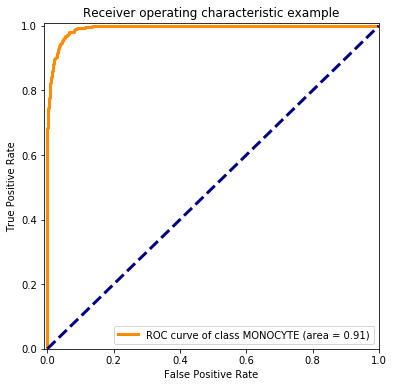

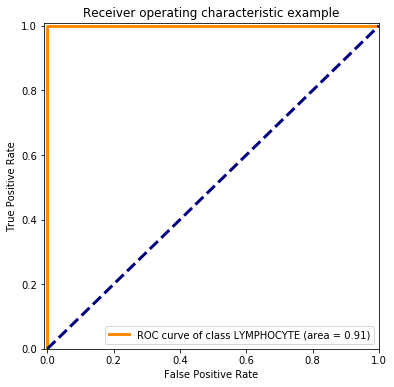

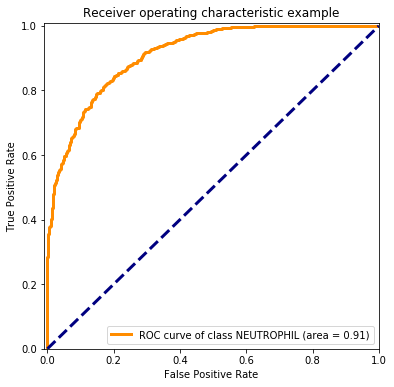

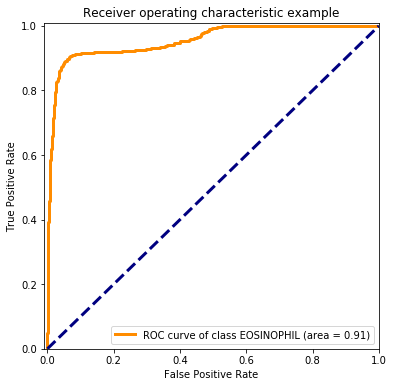

In [5]:
## 特定类型

for l in range(n_classes):
    plt.figure(figsize=(6,6))
    lw = 3
    plt.plot(fpr[l], tpr[l], color='darkorange',
            lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' .format(labels[l], roc_auc[2]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

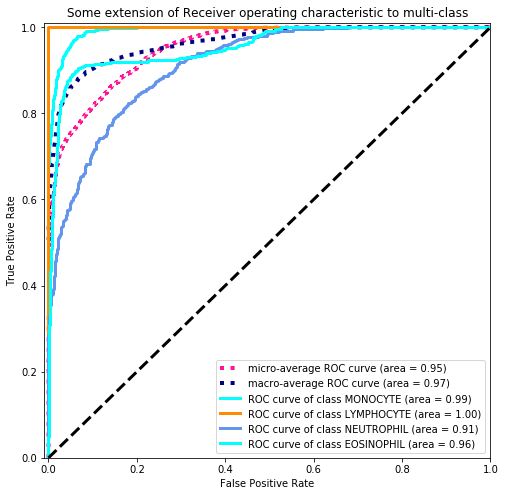

In [6]:
# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

------------Confusion Matrix------------
[[324   0 133 163]
 [  0 620   0   0]
 [  0   1 426 197]
 [  0   0  49 574]]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


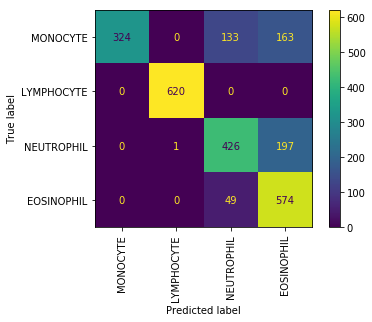

In [7]:
# Confusion Matrix
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_real, y_pre)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(xticks_rotation='vertical') 
print("------------Confusion Matrix------------")
print (cm)

In [8]:
# F1 score
from sklearn.metrics import f1_score
F1_eve = f1_score(y_real,y_pre, average = None)
F1 = np.mean(F1_eve)
print("------------F1 score------------")
for i in range(n_classes):
    print("F1 score of kind {0}: \t{1} ".format(labels[i], "%2.4f" % F1_eve[i]))
print("Total F1 score: {0}\n".format("%2.4f"%F1))

# Accuracy
print("------------Accuracy score------------")
# from sklearn.metrics import jaccard_score
# jac_acc = jaccard_score(y_real, y_pre, average=None)
# for i in range(n_classes):
#     print("precision score of kind {0}: {1} ".format(labels[i], "%2.4f" % jac_acc[i]))

from sklearn.metrics import top_k_accuracy_score
k = 3
top_k_acc = top_k_accuracy_score(y_real, Score, k=k)
print("Top {0} Accuracy score: {1}".format(k,"%2.4f"%top_k_acc))

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_real, y_pre)
print(" Accuracy score: {0}\n".format("%2.4f"%acc))

## Precision
from sklearn.metrics import precision_score
precision_eve = precision_score(y_real, y_pre, average=None)
precision = np.mean(precision_eve)
print("------------precision score------------")
for i in range(n_classes):
    print("precision score of kind {0}:\t {1} ".format(labels[i], "%2.4f" % precision_eve[i]))
print("Total precision score: {0}\n".format("%2.4f"%precision))

## Recall scora
from sklearn.metrics import recall_score
recall_score_eve = recall_score(y_real, y_pre, average=None)
recall_score = np.mean(recall_score_eve)
print("------------recall score------------")
for i in range(n_classes):
    print("recall score of kind {0}:\t {1} ".format(labels[i], "%2.4f" % recall_score_eve[i]))
print("Total recall score: {0}\n".format("%2.4f"%recall_score))


------------F1 score------------
F1 score of kind MONOCYTE: 	0.6864 
F1 score of kind LYMPHOCYTE: 	0.9992 
F1 score of kind NEUTROPHIL: 	0.6916 
F1 score of kind EOSINOPHIL: 	0.7373 
Total F1 score: 0.7786

------------Accuracy score------------
Top 3 Accuracy score: 0.9517
 Accuracy score: 0.7817

------------precision score------------
precision score of kind MONOCYTE:	 1.0000 
precision score of kind LYMPHOCYTE:	 0.9984 
precision score of kind NEUTROPHIL:	 0.7007 
precision score of kind EOSINOPHIL:	 0.6146 
Total precision score: 0.8284

------------recall score------------
recall score of kind MONOCYTE:	 0.5226 
recall score of kind LYMPHOCYTE:	 1.0000 
recall score of kind NEUTROPHIL:	 0.6827 
recall score of kind EOSINOPHIL:	 0.9213 
Total recall score: 0.7817

